In [ ]:
!pip install brax
!mkdir -p /content/output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import XML files
xml_path = '/content/drive/MyDrive/UWRS/Software/Training Notebooks/XMLs/humanoid_pos.xml'
pose_path ='/content/drive/MyDrive/UWRS/Software/Training Notebooks/XMLs/poses.xml'

In [ ]:
import jax
import jax.numpy as jp

from brax import actuator
from brax import base
from brax import envs
from brax import math
from brax.envs.base import PipelineEnv, State

import xml.etree.ElementTree as ET

from brax.io import mjcf

class MocapStandUp(PipelineEnv):
    def __init__(self, xml_path='../assets/op3/op3_simplified.xml', pose_path='../poses.xml', **kwargs):
        self.weights = {
            'reward_base_orient': 1.0,
            'reward_height': 1.0,
            'reward_ctrl': 0.1,
            'reward_up_vel': 1.0,
        }
        # define any other necessary values here

        if xml_path is None:
            raise ValueError('xml_path is required')

        # load brax system from xml file
        sys = mjcf.load(xml_path)
        super().__init__(sys, backend='mjx', **kwargs)

        # Load target q poses from poses.xml
        self.target_q_poses = self._load_target_q_poses(pose_path)

    def reset(self, rng: jp.ndarray) -> State:
        rng, rng_pos, rng_vel, mocap_rng = jax.random.split(rng, 4)

        qp = jax.random.uniform(rng_pos, (self.sys.q_size(),), jp.float32, 0.4, 1)
        qv = jax.random.uniform(rng_vel, (self.sys.qd_size(),), jp.float32, -0.01, 0.01)

        act = jp.zeros(self.sys.act_size(), jp.float32)
        pipeline_state = self.pipeline_init(qp, qv, act)
        obs = self._get_obs(pipeline_state, act)

        self.step_count = 0
        self._lambda = 500

        reward, done, zero = jp.zeros(3)

        metrics = {
            'joint_pos_reward': zero,
            'orientation_reward': zero
        }

        info = {
            'target_time': jax.random.exponential(mocap_rng, shape=(1,)),
            'target_pos_idx': jax.random.randint(mocap_rng, minval=0, maxval=len(self.target_q_poses), shape=(1,), dtype=jp.int32),
            'mocap_rng': mocap_rng
        }

        return State(pipeline_state, obs, reward, done, metrics, info)

    def step(self, state: State, action: jax.Array):
        # Scale action from [-1,1] to actuator limits
        action_min = self.sys.actuator.ctrl_range[:, 0]
        action_max = self.sys.actuator.ctrl_range[:, 1]
        action = (action + 1) * (action_max - action_min) * 0.5 + action_min

        pipeline_state = self.pipeline_step(state.pipeline_state, action)

        # # Track the number of steps until the next target pose switch
        # target_time = state.info['target_time']
        # target_time -= 1

        # # Sample new time and pos if pos switch condition met, otherwise stay
        # target_time = jp.where(target_time <= 0, jax.random.exponential(state.info['mocap_rng'], shape=(1,))*500, target_time)
        # target_pos_idx = jp.where(target_time <= 0, jax.random.randint(state.info['mocap_rng'], minval=0, maxval=len(self.target_q_poses), shape=(1,), dtype=jp.int32), state.info['target_pos_idx'])

        # target_q_pos = self.target_q_poses[target_pos_idx]
        target_q_pos = self.target_q_poses[5]

        # Calculate rewards
        joint_pos_reward = self.joint_pos_reward(pipeline_state.q, target_q_pos)
        orientation_reward = self.orientation_reward(pipeline_state.q, target_q_pos)

        reward = joint_pos_reward*orientation_reward

        obs = self._get_obs(pipeline_state, action)

        # Update metrics with rewards and state info with new target time and target pos
        state.metrics.update(joint_pos_reward=joint_pos_reward, orientation_reward=orientation_reward)
        # state.info.update(target_time=target_time, target_pos_idx=target_pos_idx)

        return state.replace(pipeline_state=pipeline_state, obs=obs, reward=reward)

    def _get_obs(
        self, pipeline_state: base.State, action: jax.Array
    ) -> jax.Array:
        """Observes humanoid body position, velocities, and angles."""
        position = pipeline_state.q[2:]
        velocity = pipeline_state.qd

        com, inertia, mass_sum, x_i = self._com(pipeline_state)
        cinr = x_i.replace(pos=x_i.pos - com).vmap().do(inertia)
        com_inertia = jp.hstack(
            [cinr.i.reshape((cinr.i.shape[0], -1)), inertia.mass[:, None]]
        )

        xd_i = (
            base.Transform.create(pos=x_i.pos - pipeline_state.x.pos)
            .vmap()
            .do(pipeline_state.xd)
        )
        com_vel = inertia.mass[:, None] * xd_i.vel / mass_sum
        com_ang = xd_i.ang
        com_velocity = jp.hstack([com_vel, com_ang])

        qfrc_actuator = actuator.to_tau(
            self.sys, action, pipeline_state.q, pipeline_state.qd
        )

        # external_contact_forces are excluded
        return jp.concatenate([
            position,
            velocity,
            com_inertia.ravel(),
            com_velocity.ravel(),
            qfrc_actuator,
        ])

    def _com(self, pipeline_state: base.State) -> jax.Array:
        inertia = self.sys.link.inertia
        if self.backend in ['spring', 'positional']:
            inertia = inertia.replace(
                i=jax.vmap(jp.diag)(
                    jax.vmap(jp.diagonal)(inertia.i)
                    ** (1 - self.sys.spring_inertia_scale)
                ),
                mass=inertia.mass ** (1 - self.sys.spring_mass_scale),
            )
        mass_sum = jp.sum(inertia.mass)
        x_i = pipeline_state.x.vmap().do(inertia.transform)
        com = (
            jp.sum(jax.vmap(jp.multiply)(inertia.mass, x_i.pos), axis=0) / mass_sum
        )
        return com, inertia, mass_sum, x_i

    def _load_target_q_poses(self, poses_path):
        tree = ET.parse(poses_path)
        root = tree.getroot()
        target_q_poses = []

        for key in root.findall('key'):
            qpos = key.get('qpos')
            q_values = qpos.split()
            q_values = [float(q) for q in q_values]
            target_q_poses.append(q_values)

        return jp.array(target_q_poses)

    def joint_pos_reward(self, joint_pos: jax.Array, target_q_pos: jax.Array):
        joint_pos = joint_pos[7:]
        target_q_pos = target_q_pos[7:]

        error = (jp.pi - jp.linalg.norm(target_q_pos - joint_pos)) / jp.pi
        return error

    def orientation_reward(self, joint_pos: jax.Array, target_q_pos: jax.Array):
        body_pos = joint_pos[3:7]
        target_body_pos = target_q_pos[3:7]
        up = jp.array([0, 0, 1], jp.float32)

        body_orientation = math.rotate(up, body_pos)
        target_orientation = math.rotate(up, target_body_pos)

        # error = (jp.pi - jp.arccos(jp.dot(body_orientation, target_orientation))) / jp.pi
        error = (jp.pi - jp.arccos(jp.clip(jp.dot(body_orientation, target_orientation), -1, 1))) / jp.pi
        return error


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Metrics: {'eval/walltime': 58.49206900596619, 'eval/episode_joint_pos_reward': Array(-872.85864, dtype=float32), 'eval/episode_orientation_reward': Array(878.7306, dtype=float32), 'eval/episode_reward': Array(-294.84354, dtype=float32), 'eval/episode_joint_pos_reward_std': Array(681.22125, dtype=float32), 'eval/episode_orientation_reward_std': Array(479.15738, dtype=float32), 'eval/episode_reward_std': Array(338.30704, dtype=float32), 'eval/avg_episode_length': Array(2000., dtype=float32), 'eval/epoch_eval_time': 58.49206900596619, 'eval/sps': 4376.661731249206}


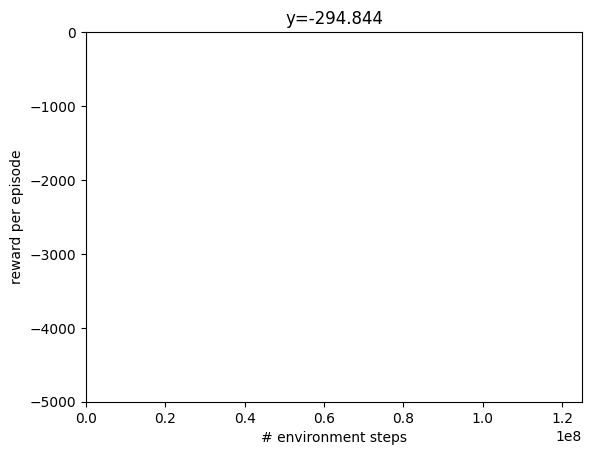

Metrics: {'eval/walltime': 79.36482000350952, 'training/sps': 104944.83968495052, 'training/walltime': 238.86376953125, 'training/entropy_loss': Array(-0.09638977, dtype=float32), 'training/policy_loss': Array(-0.00745004, dtype=float32), 'training/total_loss': Array(-0.10225353, dtype=float32), 'training/v_loss': Array(0.00158627, dtype=float32), 'eval/episode_joint_pos_reward': Array(135.90234, dtype=float32), 'eval/episode_orientation_reward': Array(874.5998, dtype=float32), 'eval/episode_reward': Array(102.853, dtype=float32), 'eval/episode_joint_pos_reward_std': Array(535.29315, dtype=float32), 'eval/episode_orientation_reward_std': Array(343.73718, dtype=float32), 'eval/episode_reward_std': Array(286.75305, dtype=float32), 'eval/avg_episode_length': Array(2000., dtype=float32), 'eval/epoch_eval_time': 20.872750997543335, 'eval/sps': 12264.794421690292}


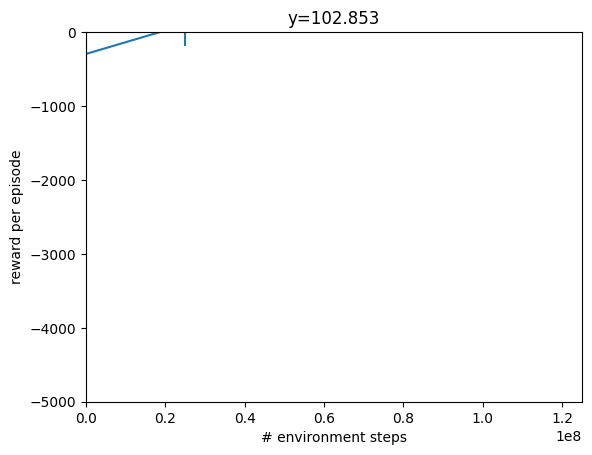

Metrics: {'eval/walltime': 100.4980092048645, 'training/sps': 122124.27089664631, 'training/walltime': 444.12616181373596, 'training/entropy_loss': Array(-0.09214698, dtype=float32), 'training/policy_loss': Array(-0.00935583, dtype=float32), 'training/total_loss': Array(-0.10000459, dtype=float32), 'training/v_loss': Array(0.00149822, dtype=float32), 'eval/episode_joint_pos_reward': Array(154.21883, dtype=float32), 'eval/episode_orientation_reward': Array(878.59814, dtype=float32), 'eval/episode_reward': Array(131.14944, dtype=float32), 'eval/episode_joint_pos_reward_std': Array(573.0613, dtype=float32), 'eval/episode_orientation_reward_std': Array(387.50278, dtype=float32), 'eval/episode_reward_std': Array(307.6099, dtype=float32), 'eval/avg_episode_length': Array(2000., dtype=float32), 'eval/epoch_eval_time': 21.13318920135498, 'eval/sps': 12113.64728536033}


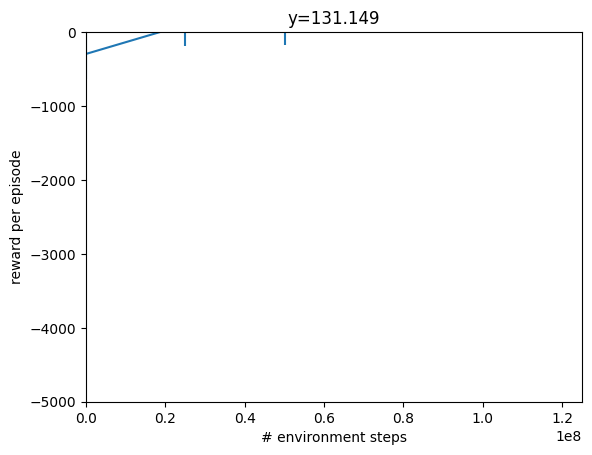

Metrics: {'eval/walltime': 121.20331025123596, 'training/sps': 122005.47747059619, 'training/walltime': 649.5884125232697, 'training/entropy_loss': Array(-0.08992863, dtype=float32), 'training/policy_loss': Array(-0.00904447, dtype=float32), 'training/total_loss': Array(-0.09723239, dtype=float32), 'training/v_loss': Array(0.00174072, dtype=float32), 'eval/episode_joint_pos_reward': Array(202.40405, dtype=float32), 'eval/episode_orientation_reward': Array(970.10535, dtype=float32), 'eval/episode_reward': Array(180.79596, dtype=float32), 'eval/episode_joint_pos_reward_std': Array(649.44196, dtype=float32), 'eval/episode_orientation_reward_std': Array(434.9595, dtype=float32), 'eval/episode_reward_std': Array(382.45447, dtype=float32), 'eval/avg_episode_length': Array(2000., dtype=float32), 'eval/epoch_eval_time': 20.70530104637146, 'eval/sps': 12363.9834758579}


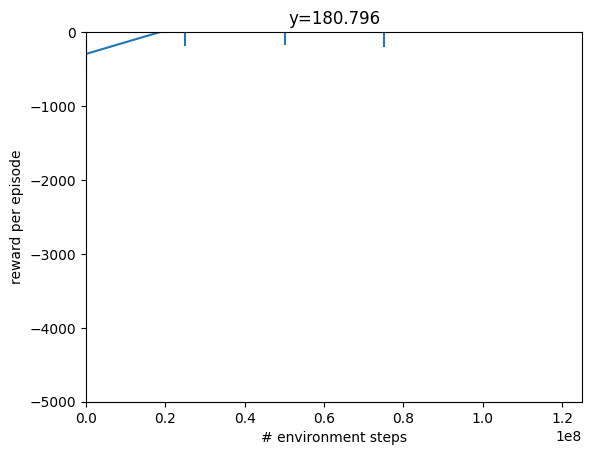

Metrics: {'eval/walltime': 141.83348894119263, 'training/sps': 122659.7432228213, 'training/walltime': 853.9547297954559, 'training/entropy_loss': Array(-0.08733836, dtype=float32), 'training/policy_loss': Array(-0.00856892, dtype=float32), 'training/total_loss': Array(-0.09422404, dtype=float32), 'training/v_loss': Array(0.00168323, dtype=float32), 'eval/episode_joint_pos_reward': Array(214.75287, dtype=float32), 'eval/episode_orientation_reward': Array(969.80304, dtype=float32), 'eval/episode_reward': Array(184.94766, dtype=float32), 'eval/episode_joint_pos_reward_std': Array(535.52814, dtype=float32), 'eval/episode_orientation_reward_std': Array(493.93735, dtype=float32), 'eval/episode_reward_std': Array(322.68542, dtype=float32), 'eval/avg_episode_length': Array(2000., dtype=float32), 'eval/epoch_eval_time': 20.630178689956665, 'eval/sps': 12409.005459784397}


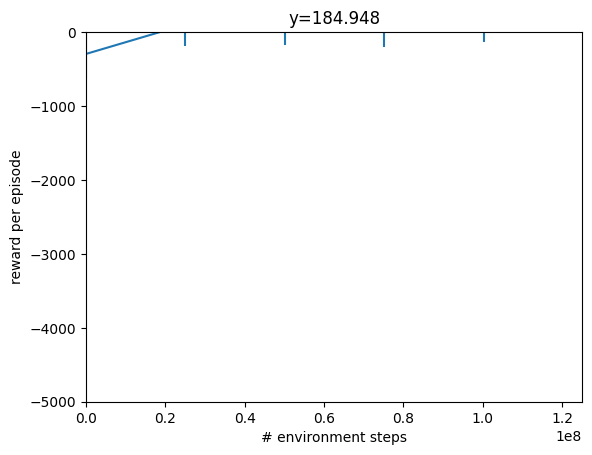

time to jit: 0:01:16.248977
time to train: 0:15:37.975457


In [ ]:
from brax import envs
from brax.training.agents.ppo import train as ppo
from brax.io import model

from datetime import datetime

import functools

import jax

from matplotlib import pyplot as plt

envs.register_environment('humanoid-standup', MocapStandUp)
env = envs.get_environment('humanoid-standup', xml_path=xml_path, pose_path=pose_path)

jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

train_fn = functools.partial(
    ppo.train, num_timesteps=100_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=2000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=24, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=3072,
    batch_size=512, seed=0
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 0, -5000
def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics['eval/episode_reward'])
    ydataerr.append(metrics['eval/episode_reward_std'])
    print(f'Metrics: {metrics}')

    plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel('# environment steps')
    plt.ylabel('reward per episode')
    plt.title(f'y={y_data[-1]:.3f}')

    plt.errorbar(
        x_data, y_data, yerr=ydataerr)
    plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)
model.save_params('output/params', params)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')